# Radial Flow VAE 

In this notebook we experiment with vae with Normalizing Flow.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tfd
import tfgraphviz as tfg
from tqdm import tqdm_notebook
import itertools
import sys
sys.path.append("../src")
import simulation 
from IPython.core.debugger import Tracer
import seaborn as sns

## Experiment 0 : Radial Flow

In [2]:
# We instantiate the session
tf.reset_default_graph()
net_session = tf.InteractiveSession()

In [3]:
# We draw samples from Isotropic Gaussian
net_eps = tf.placeholder(tf.float32, shape=[None,2])   
# We set flow parameters
c = tf.constant([[.0,.0]])
c = tf.tile(c,[tf.shape(net_eps)[0],1])
a = tf.constant([0.000001])
a = tf.tile(a,[tf.shape(net_eps)[0]])
b = tf.constant([-.01])
b = tf.tile(b,[tf.shape(net_eps)[0]])
# We enforce the invertibility
b_c = -a+tf.nn.softplus(b)
# We compute flow
r = tf.norm(net_eps - c, axis=1)
h = 1/(a+r)
vals = tf.multiply(b_c,h)
flow = tf.einsum('i,ij->ij', vals , net_eps-c)
net_flow = net_eps + flow

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


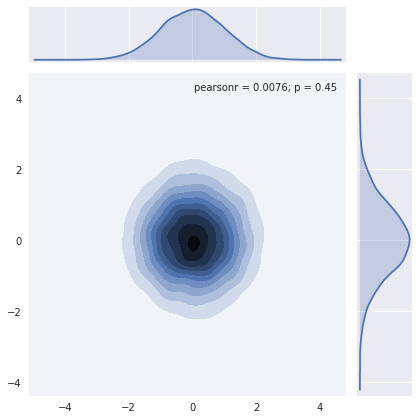

In [4]:
# We sample from Isotropic Gaussian:
X = np.random.randn(10000,2)
sns.jointplot(X[:,0], X[:,1],kind="kde");

In [5]:
# We initialize variables
net_session.run(tf.global_variables_initializer())

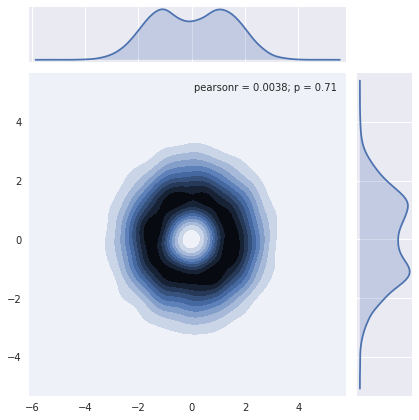

In [6]:
# We compute the flow and plot it
X_f = net_flow.eval(feed_dict={net_eps:X})
sns.jointplot(X_f[:,0], X_f[:,1],kind="kde");

## Experiment 1: Rotating Arrow

In [7]:
# We gather simulation
sim = simulation.RotatingArrowSimulation()

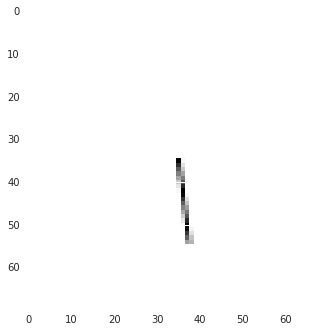

In [8]:
# We set sizes
im_size = 70
nb_samples = 500
# We instantiate the numpy array
X = sim.sample_trajectory([0.], [1.], nb_samples).reshape([-1,im_size**2])
# We check that our function works expectedly
plt.imshow(X[10].reshape(im_size,im_size))
plt.show()

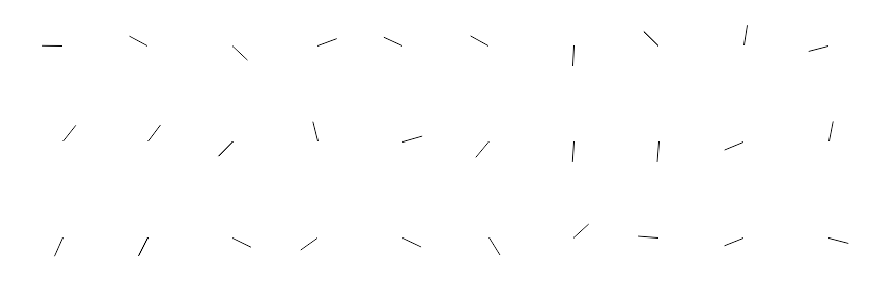

In [9]:
# We plot samples
fig, ax = plt.subplots(ncols=10, nrows=3,figsize=(15,5))
for x,y in itertools.product(range(3), range(10)):
    ax[x,y].imshow(X[np.random.randint(X.shape[0])].reshape(im_size, im_size))
    ax[x,y].axis('off')

In [10]:
# We instantiate the session
tf.reset_default_graph()
net_session = tf.InteractiveSession()

In [11]:
# We set the embedding size
emb_size = 2
nb_trans = 10
# We set the data size
data_sz = im_size**2

In [12]:
# We set the network architecture
with tf.variable_scope("Input"):
    net_input = tf.placeholder(tf.float32, shape=[None,data_sz])    
    
with tf.variable_scope("Encoder"):
    
    # Non-Linear Layer
    net_enc_w1 = tf.Variable(tf.truncated_normal([data_sz, 400], stddev=0.001))
    net_enc_b1 = tf.Variable(tf.constant(0., shape=[400]))
    net_enc_h1 = tf.nn.relu(tf.matmul(net_input, net_enc_w1) + net_enc_b1)
    # Mu output layer
    net_enc_w2 = tf.Variable(tf.truncated_normal([400,emb_size], stddev=0.001))
    net_enc_b2 = tf.Variable(tf.constant(0., shape=[emb_size]))
    net_enc_mu = tf.matmul(net_enc_h1, net_enc_w2) + net_enc_b2
    # Log Var output layer
    net_enc_w3 = tf.Variable(tf.truncated_normal([400,emb_size], stddev=0.001))
    net_enc_b3 = tf.Variable(tf.constant(0., shape=[emb_size]))
    net_enc_log_var = tf.matmul(net_enc_h1, net_enc_w3) + net_enc_b3
    # Lambda output layers
    net_enc_w4 = tf.Variable(tf.truncated_normal([400, nb_trans*emb_size], stddev=0.001))
    net_enc_b4 = tf.Variable(tf.constant(0., shape=[nb_trans*emb_size]))
    net_enc_cs = tf.matmul(net_enc_h1, net_enc_w4) + net_enc_b4
    net_enc_cs = tf.reshape(net_enc_cs, [-1, nb_trans, emb_size])
    net_enc_w5 = tf.Variable(tf.truncated_normal([400, nb_trans], stddev=0.001))
    net_enc_b5 = tf.Variable(tf.constant(0., shape=[nb_trans]))
    net_enc_bs = tf.matmul(net_enc_h1, net_enc_w5) + net_enc_b5
    net_enc_w6 = tf.Variable(tf.truncated_normal([400, nb_trans], stddev=0.001))
    net_enc_b6 = tf.Variable(tf.constant(0., shape=[nb_trans]))
    net_enc_as = tf.matmul(net_enc_h1, net_enc_w6) + net_enc_b6  
    
with tf.variable_scope("Reparametrization"):
    net_rep_eps = tf.random_normal([emb_size])
    net_rep_mu = net_enc_mu
    net_rep_sigma = tf.exp(net_enc_log_var/2.)
    net_rep_z = net_enc_mu + tf.multiply(net_rep_eps, net_rep_sigma)
    
with tf.variable_scope("Radial_Flow"):
    net_flow_log_det_jacs = 0
    net_flow_output = net_rep_z
    for k in range(nb_trans):
        # We retrieve the parameters
        c = net_enc_cs[:,k]
        a = tf.abs(net_enc_as[:,k])
        b = net_enc_bs[:,k]
        # We enforce the invertibility
        b_c = -a+tf.nn.softplus(b)
        # We compute flow
        r = tf.norm(net_flow_output - c, axis=1)
        h = 1/(a+r)
        bh = tf.multiply(b_c,h)
        flow = tf.einsum('i,ij->ij', bh, net_flow_output-c)
        net_flow_output = net_flow_output + flow
        # We compute log det
        log_det_jac = - 1/ tf.square(a + r)
        log_det_jac = log_det_jac * tf.expand_dims(b_c, axis=1) * r
        log_det_jac = log_det_jac + 1 + bh
        log_det_jac = log_det_jac * tf.pow(1+bh, emb_size-1)
        log_det_jac = tf.log(tf.clip_by_value(log_det_jac, 1e-4, 1e7))
        net_flow_log_det_jacs = net_flow_log_det_jacs + log_det_jac
        
with tf.variable_scope("Decoder"):
    net_dec_w1 = tf.Variable(tf.truncated_normal([emb_size, 400], stddev=0.001))
    net_dec_b1 = tf.Variable(tf.constant(0., shape=[400]))
    net_dec_h1 = tf.nn.relu(tf.matmul(net_flow_output, net_dec_w1) + net_dec_b1)
    
    net_dec_w2 = tf.Variable(tf.truncated_normal([400, data_sz], stddev=0.001))
    net_dec_b2 = tf.Variable(tf.constant(0., shape=[data_sz]))
    net_dec_h2 = tf.matmul(net_dec_h1, net_dec_w2) + net_dec_b2
    
    net_output = tf.nn.sigmoid(net_dec_h2)
    
with tf.variable_scope("Loss/Optim"):
    net_time_step = tf.placeholder(tf.float32, shape=[1])
    net_annealing = tf.minimum(1.,0.01+net_time_step/10000.)
    net_loss_kld = 1 + net_enc_log_var - tf.square(net_enc_mu) - tf.exp(net_enc_log_var)
    net_loss_kld = - beta * 0.5 * tf.reduce_sum(net_loss_kld, reduction_indices=1)
    net_loss_lkh = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=net_dec_h2, labels=net_input), reduction_indices=1)
    net_loss_flow = - net_flow_log_det_jacs
    net_loss_loss = tf.reduce_mean( net_annealing*(net_loss_lkh + net_loss_kld )+ net_loss_flow)
    net_opt_step = tf.train.AdamOptimizer(0.001).minimize(net_loss_loss)

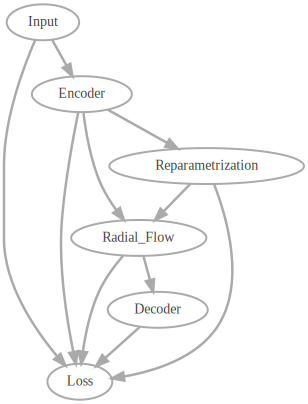

In [13]:
# We check the network
tfg.board(net_session.graph, depth=1)

In [20]:
# We initialize variables
net_session.run(tf.global_variables_initializer())
t=0.

In [21]:
# We define epochs and batch size
epochs = int(2e4)
batch_size = 100
hist = np.zeros(epochs)
# We train the network with some batches
for i in tqdm_notebook(range(epochs),desc="Training network"):
    idx = np.random.permutation(X.shape[0])[:batch_size]
    feed_dict = {net_input:X[idx], net_time_step:[t]}
    hist[i] = net_loss_loss.eval(feed_dict=feed_dict)
    net_opt_step.run(feed_dict=feed_dict)
    t +=1

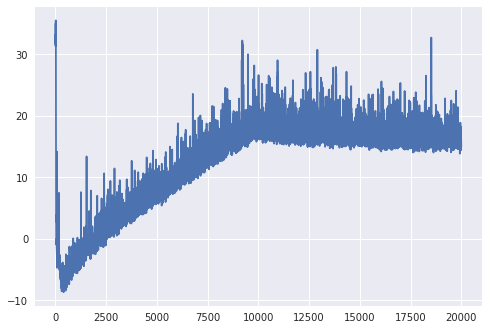

In [22]:
# We plot the learning curve
plt.plot(hist)
plt.show()

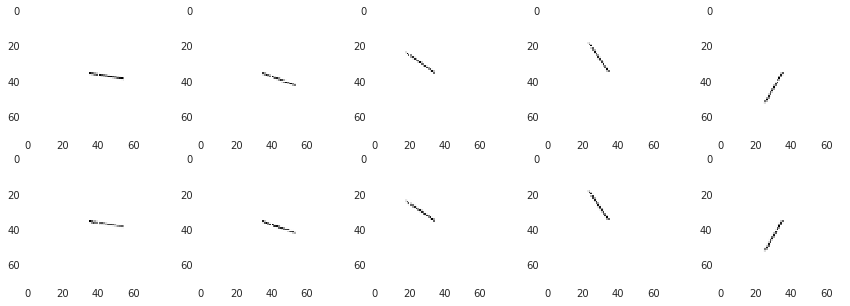

In [23]:
# We show reconstruction for some training samples
nb_draw = 5
idx = np.random.permutation(range(X.shape[0]))[0:nb_draw]
inpt = X[idx]
outpt = net_output.eval(feed_dict={net_input:inpt}) 
fig, ax = plt.subplots(ncols=nb_draw, nrows=2,figsize=(15,5))
for i in range(nb_draw):
    ax[0,i].imshow(inpt[i].reshape([im_size, im_size]))
    ax[1,i].imshow(outpt[i].reshape([im_size, im_size]))

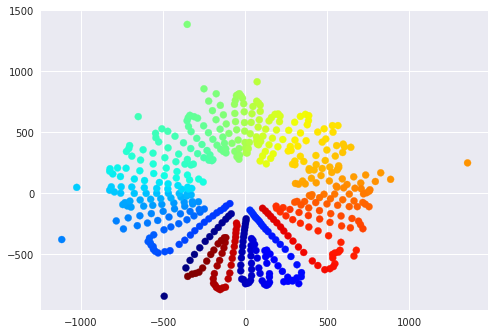

In [24]:
# We plot embedding variables evolution for rotating arrow
inpt = X
emb = net_flow_output.eval(feed_dict={net_input:inpt})
plt.scatter(emb[:,0], emb[:,1], c=range(X.shape[0]), cmap='jet')

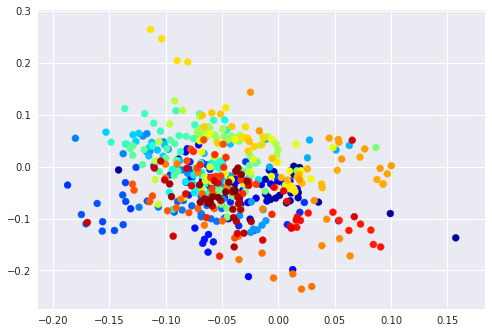

In [25]:
# We plot embedding variables evolution for rotating arrow
inpt = X
emb = net_enc_mu.eval(feed_dict={net_input:inpt}) 
plt.scatter(emb[:,0], emb[:,1], c=range(X.shape[0]), cmap='jet')

## Experiment 2: Bouncing ball

In [20]:
sim = simulation.TranslatingBallSimulation()

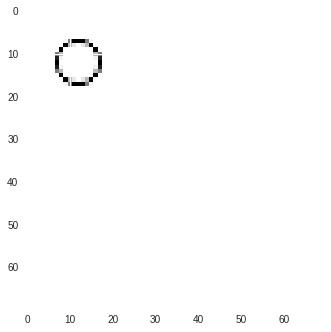

In [21]:
# We set sizes
im_size = 70
nb_samples = 30
# We generate data
X = sim.sample_all_factors(30).reshape([-1,im_size**2])
# We plot a sample 
plt.imshow(X[155].reshape([im_size, im_size]))
plt.show();

In [22]:
# We instantiate the session
tf.reset_default_graph()
net_session = tf.InteractiveSession()

In [24]:
# We set the embedding size
emb_size = 2
nb_trans = 10
# We set the data size
data_sz = im_size**2

In [25]:
# We set the network architecture
with tf.variable_scope("Input"):
    net_input = tf.placeholder(tf.float32, shape=[None,data_sz])    
    
with tf.variable_scope("Encoder"):
    
    # Non-Linear Layer
    net_enc_w1 = tf.Variable(tf.truncated_normal([data_sz, 400], stddev=0.001))
    net_enc_b1 = tf.Variable(tf.constant(0., shape=[400]))
    net_enc_h1 = tf.nn.relu(tf.matmul(net_input, net_enc_w1) + net_enc_b1)
    # Mu output layer
    net_enc_w2 = tf.Variable(tf.truncated_normal([400,emb_size], stddev=0.001))
    net_enc_b2 = tf.Variable(tf.constant(0., shape=[emb_size]))
    net_enc_mu = tf.matmul(net_enc_h1, net_enc_w2) + net_enc_b2
    # Log Var output layer
    net_enc_w3 = tf.Variable(tf.truncated_normal([400,emb_size], stddev=0.001))
    net_enc_b3 = tf.Variable(tf.constant(0., shape=[emb_size]))
    net_enc_log_var = tf.matmul(net_enc_h1, net_enc_w3) + net_enc_b3
    # Lambda output layers
    net_enc_w4 = tf.Variable(tf.truncated_normal([400, nb_trans*emb_size], stddev=0.001))
    net_enc_b4 = tf.Variable(tf.constant(0., shape=[nb_trans*emb_size]))
    net_enc_cs = tf.matmul(net_enc_h1, net_enc_w4) + net_enc_b4
    net_enc_cs = tf.reshape(net_enc_cs, [-1, nb_trans, emb_size])
    net_enc_w5 = tf.Variable(tf.truncated_normal([400, nb_trans], stddev=0.001))
    net_enc_b5 = tf.Variable(tf.constant(0., shape=[nb_trans]))
    net_enc_bs = tf.matmul(net_enc_h1, net_enc_w5) + net_enc_b5
    net_enc_w6 = tf.Variable(tf.truncated_normal([400, nb_trans], stddev=0.001))
    net_enc_b6 = tf.Variable(tf.constant(0., shape=[nb_trans]))
    net_enc_as = tf.matmul(net_enc_h1, net_enc_w6) + net_enc_b6  
    
with tf.variable_scope("Reparametrization"):
    net_rep_eps = tf.random_normal([emb_size])
    net_rep_mu = net_enc_mu
    net_rep_sigma = tf.exp(net_enc_log_var/2.)
    net_rep_z = net_enc_mu + tf.multiply(net_rep_eps, net_rep_sigma)
    
with tf.variable_scope("Radial_Flow"):
    net_flow_log_det_jacs = 0
    net_flow_output = net_rep_z
    for k in range(nb_trans):
        # We retrieve the parameters
        c = net_enc_cs[:,k]
        a = tf.abs(net_enc_as[:,k])
        b = net_enc_bs[:,k]
        # We enforce the invertibility
        b_c = -a+tf.nn.softplus(b)
        # We compute flow
        r = tf.norm(net_flow_output - c, axis=1)
        h = 1/(a+r)
        bh = tf.multiply(b_c,h)
        flow = tf.einsum('i,ij->ij', bh, net_flow_output-c)
        net_flow_output = net_flow_output + flow
        # We compute log det
        log_det_jac = - 1/ tf.square(a + r)
        log_det_jac = log_det_jac * tf.expand_dims(b_c, axis=1) * r
        log_det_jac = log_det_jac + 1 + bh
        log_det_jac = log_det_jac * tf.pow(1+bh, emb_size-1)
        log_det_jac = tf.log(tf.clip_by_value(log_det_jac, 1e-4, 1e7))
        net_flow_log_det_jacs = net_flow_log_det_jacs + log_det_jac
        
with tf.variable_scope("Decoder"):
    net_dec_w1 = tf.Variable(tf.truncated_normal([emb_size, 400], stddev=0.001))
    net_dec_b1 = tf.Variable(tf.constant(0., shape=[400]))
    net_dec_h1 = tf.nn.relu(tf.matmul(net_flow_output, net_dec_w1) + net_dec_b1)
    
    net_dec_w2 = tf.Variable(tf.truncated_normal([400, data_sz], stddev=0.001))
    net_dec_b2 = tf.Variable(tf.constant(0., shape=[data_sz]))
    net_dec_h2 = tf.matmul(net_dec_h1, net_dec_w2) + net_dec_b2
    
    net_output = tf.nn.sigmoid(net_dec_h2)
    
with tf.variable_scope("Loss/Optim"):
    net_time_step = tf.placeholder(tf.float32, shape=[1])
    net_annealing = tf.minimum(1.,0.01+net_time_step/10000.)
    net_loss_kld = 1 + net_enc_log_var - tf.square(net_enc_mu) - tf.exp(net_enc_log_var)
    net_loss_kld = - beta * 0.5 * tf.reduce_sum(net_loss_kld, reduction_indices=1)
    net_loss_lkh = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=net_dec_h2, labels=net_input), reduction_indices=1)
    net_loss_flow = - net_flow_log_det_jacs
    net_loss_loss = tf.reduce_mean( net_annealing*(net_loss_lkh + net_loss_kld )+ net_loss_flow)
    net_opt_step = tf.train.AdamOptimizer(0.001).minimize(net_loss_loss)

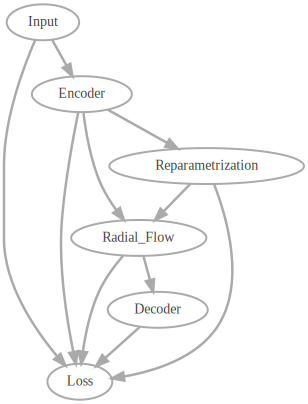

In [26]:
# We check the network
tfg.board(net_session.graph, depth=1)

In [27]:
# We initialize variables
net_session.run(tf.global_variables_initializer())
t=0.

In [ ]:
# We define epochs and batch size
epochs = int(2e4)
batch_size = 100
hist = np.zeros(epochs)
# We train the network with some batches
for i in tqdm_notebook(range(epochs),desc="Training network"):
    idx = np.random.permutation(X.shape[0])[:batch_size]
    feed_dict = {net_input:X[idx], net_time_step:[t]}
    hist[i] = net_loss_loss.eval(feed_dict=feed_dict)
    net_opt_step.run(feed_dict=feed_dict)

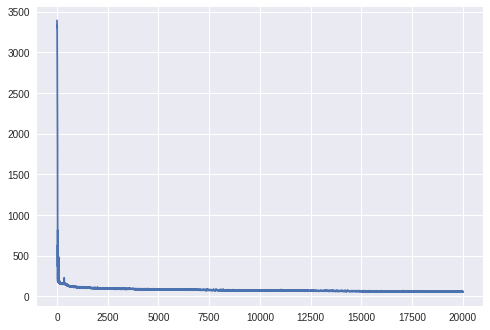

In [30]:
# We plot the learning curve
plt.plot(hist)
plt.show()

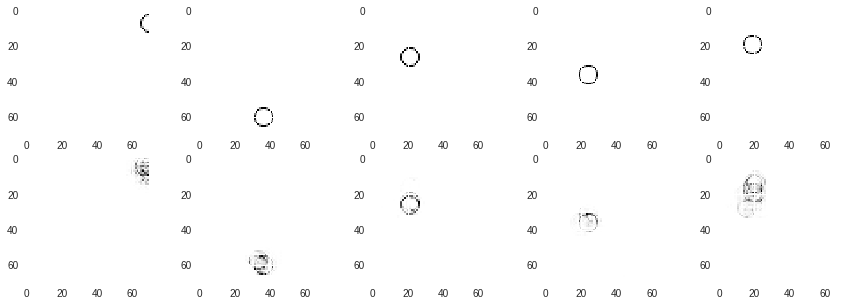

In [31]:
# We show reconstruction for some training samples
nb_draw = 5
idx = np.random.permutation(range(X.shape[0]))[0:nb_draw]
inpt = X[idx]
outpt = net_output.eval(feed_dict={net_input:inpt}) 
fig, ax = plt.subplots(ncols=nb_draw, nrows=2,figsize=(15,5))
for i in range(nb_draw):
    ax[0,i].imshow(inpt[i].reshape([im_size, im_size]))
    ax[1,i].imshow(outpt[i].reshape([im_size, im_size]))

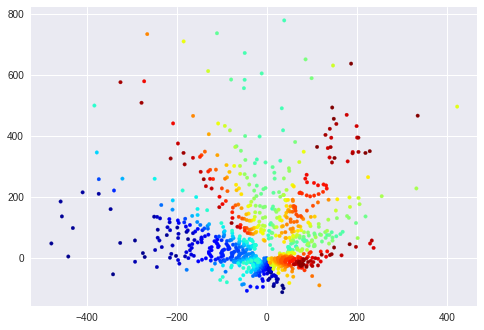

In [32]:
# We plot embedding variables evolution for rotating arrow
inpt = X
emb = net_flow_output.eval(feed_dict={net_input:inpt}) 
plt.scatter(emb[:,0], emb[:,1], c=range(X.shape[0]), cmap='jet', marker='.')

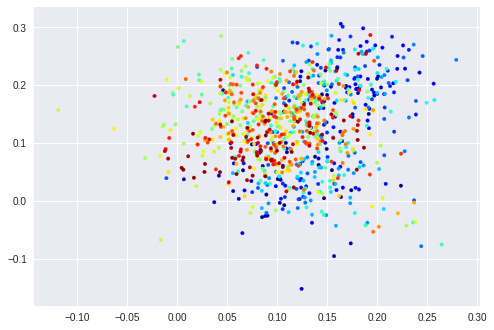

In [33]:
# We plot embedding variables evolution for rotating arrow
inpt = X
emb = net_enc_mu.eval(feed_dict={net_input:inpt}) 
plt.scatter(emb[:,0], emb[:,1], c=range(X.shape[0]), cmap='jet', marker='.')